# How does data cleaning and score metric affect whose the top performing artist/track


This analysis is done for a Data Analytics Consultant Group in order to give information about how much of a difference different data cleaning and score metrics actually makes on the final analysis. Essentially is it worth the work.

# Exploratory data analysis

### loading data


In [296]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt



#### defining functions for loading the data.

In [297]:
def exponential_score(x):# Function to calculate an exponential score based on position
    return round((107.3 * x ** (-0.402)),0).astype('int')

def primitive_score(x):# Function to calculate a primitive score (inverse of position)
    return((x*-1)+101).astype('int')

def dividing_score(x):# Function to calculate a dividing score based on a custom formula
    return round((20/(x)-0.5*(x)+75)*1.058).astype('int')

def logbased_score(x):# Function to calculate a logarithmic-based score
    return round(-15.79*np.log(x+1)+88.06).astype('int')

def composite_score(x):# Function to calculate a composite score (average of log-based and exponential scores)
    return (logbased_score(x) + exponential_score(x))/2

def load_data(name,bool): # Function to load data from a CSV file, remove duplicates, and return a DataFrame
    if bool==True:
        data= pd.read_csv(name+'.csv',index_col=0)
    else:
        data= pd.read_csv(name+'.csv')    
    data= data.drop_duplicates()
    return data

def merge_track(table_1,table_2):# Function to merge two tables based on 'track_id'
    data=pd.merge(table_1,table_2,left_on='track_id',right_on='track_id',how='left')
    return data

def merge_artist(table_1,table_2):# Function to merge two tables based on 'artist_id'
    data=pd.merge(table_1,table_2,left_on='artist_id',right_on='artist_id',how='left')
    return data

def chart_manipulate():# Function to manipulate the 'chart' DataFrame by adding calculated scores
    chart['chart_year']=pd.to_datetime(chart['chart_week']).dt.year
    chart['primitive_score']=primitive_score(chart['list_position'])
    chart['dividing_score']=dividing_score(chart['list_position'])
    chart['logbased_score']=logbased_score(chart['list_position'])
    chart['exponential_score']=exponential_score(chart['list_position'])
    chart['composite_score']=composite_score(chart['list_position'])
    return chart


## loading data

In [298]:
chart=load_data('chart',True)
artist=load_data('artist',True)
tracks=load_data('tracks',True)
#load mapping file and drop first column if it's a duplicate of columns name
mapping=load_data('mapping',True)
if mapping.iloc[0,0]=='artist_id':
    mapping=mapping.drop([0])
else:
    print('no need to drop first row')
#load updated mapping file and drop first column if it's a duplicate of columns name
up_mapping=load_data('updated_mapping',False)
if up_mapping.iloc[0,0]=='artist_id':
    up_mapping=up_mapping.drop([0])
else:
    print('no need to drop first row')

#manipulate chart data
chart=chart_manipulate()

# merge to one big datatable
map_artist=merge_artist(mapping,artist)
artist_track=merge_track(map_artist,tracks)
data=merge_track(artist_track,chart)

# merge updated to one big datatable
up_map_artist=merge_artist(up_mapping,artist)
up_artist_track=merge_track(up_map_artist,tracks)
up_data=merge_track(up_artist_track,chart)

# additional tables for specific arguments
artist_to_compare=load_data('artist_to_compare',False)
artist_to_compare=artist_to_compare.rename(columns={'name':'closest_match'})

no need to drop first row


downloaded spotify amount of streams each week from kaggle. 

this is to try and find the average reach of every top song each week, how many person have listened to this song. I will later base my Scoring formula from this measure. I compare how good the formulas are to this metric.


In [299]:
df_100=load_data('spotify_top_100/global_weekly_top_200_2017to2020',True)
df_100=df_100[['Position','start_week','Streams']]
df_100=df_100.groupby('Position').mean(numeric_only=True).astype('int').head(100) #calculate average amount of plays for each chart position
df_100['Streams']=(df_100['Streams']/(df_100['Streams'].max()))*100 # normalize so that position 1 have 100 and it drops off as a percentage of the max value 

## comparing different scoring models with spotify data.

this code is to get a formula for a exponential decay curve. by visual observation i thought this would be a good match. i then plot it against the data

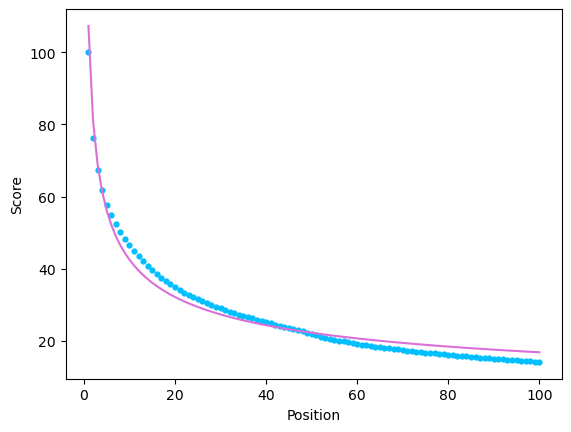

Parameters: [107.30489899   0.40199863]


In [300]:

def exponential_score(x, a, b):
    return a * x ** (-b)
x=df_100.index
y=df_100['Streams']
# Fit function, it tries different variations of a and b to see which combination thats fit the data the best
parameters, _ = curve_fit(exponential_score, x, y )

# Generate fitted values
value_formula = exponential_score(x,*parameters)
# Plot data and formula
plt.plot(x, value_formula, color='orchid')
plt.scatter(x, y, color='deepskyblue', s=12)
plt.xlabel("Position")
plt.ylabel("Score")
plt.show()

print(f"Parameters: {parameters}")



### Different Score Functions 

1. **Primitive_score :**  is just an inverted function, so that position 1 get 100 point and then it drop off by one all the way down the list
2. **Dividing_score :** is a formula that i initially concaved when taking an initial look at the data. this is here so that we can compare a formula which is 'tailored' to the available data but not systematically by best practice designed.
3. **Logbased_score :** is from our group-work where we got the data from top 100 song globally but only for one week. then the data was inputted in chatgpt and asked to give it's best formula to predict the data. 
4. **Exponential_score :** is from analyzing the structure of the data and then applying a algorithm to get the best formula for that shape.
5. **Composite_score:** the composite formula is the mean of the logbased and exponential formula. since the both under and overestimate at different times in the plot it will bring the final result closer to the actual truth. this was found by analyzing the diff graph and seeing a possibility to merge them.

applying all different score system to the formula to compare

In [301]:
def primitive_score(x):
    return((x*-1)+101).astype('int')

def dividing_score(x):
    return (20/(x)-0.5*(x)+75)*1.058

def logbased_score(x):
    return -15.79*np.log(x+1)+88.06

def exponential_score(x):
    return (107.3 * x ** (-0.402))

def composite_score(x): #redefining the formula to incorporate the parameters
    return (logbased_score(x) + exponential_score(x))/2


df_100['exponential_score']=exponential_score(df_100.index)
df_100['primitive_score']=primitive_score(df_100.index)
df_100['dividing_score']=dividing_score(df_100.index)
df_100['logbased_score']=logbased_score(df_100.index)
df_100['composite_score']=composite_score(df_100.index)

df_100['exponential_score']=round(df_100['exponential_score'],0).astype('int')
df_100['dividing_score']=round(df_100['dividing_score'],0).astype('int')
df_100['logbased_score']=round(df_100['logbased_score'],0).astype('int')
df_100['composite_score']=round(df_100['composite_score'],0).astype('int')



### defining plot function to use in main findings

In [302]:
def score_100_0():
    x=df_100.index
    y=df_100['Streams']
    exponantial_score_plot = exponential_score(x)
    primitive_score_plot=primitive_score(x)
    dividing_score_plot=dividing_score(x)
    logbased_score_plot=logbased_score(x)
    composite_score_plot=composite_score(x)
    # Plot data and formula

    plt.plot(x, primitive_score_plot, color='orange', linestyle=':',linewidth=2,label='Primitive Score')
    plt.plot(x, dividing_score_plot, color='aquamarine',linestyle='-.',linewidth=2,label='Dividing Score')
    plt.plot(x, logbased_score_plot, color='yellowgreen',linestyle='--',linewidth=2,label='Logbased Score')
    plt.plot(x, exponantial_score_plot, color='orchid', linestyle='-',linewidth=2,label='Exponantial Score')
    plt.plot(x, composite_score_plot, color='crimson', linestyle=(0, (3, 2, 1, 2)),linewidth=2,label='Composite Score')
    plt.scatter(x, y, color='deepskyblue', s=10,label='Data Points')

    # Add a legend in the top right corner
    plt.legend(loc='upper right', fontsize=10)
    plt.xlabel("Position")
    plt.ylabel("Score")
    return plt.show()

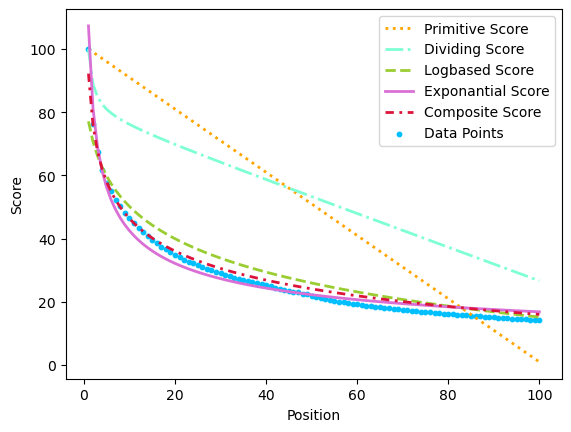

In [303]:
score_100_0()

the graph shows there 2 big winners , the log and exponential formula

In [304]:
def score_100_0_diff():
    plt.plot(x,df_100[['Streams','exponential_score']].diff(periods=1,axis=1)['exponential_score'], color='orchid', linestyle='-',linewidth=2,label='Exponantial Score')
    plt.plot(x,df_100[['Streams','primitive_score']].diff(periods=1,axis=1)['primitive_score'],color='orange', linestyle=':',linewidth=2,label='Primitive Score')
    plt.plot(x,df_100[['Streams','dividing_score']].diff(periods=1,axis=1)['dividing_score'], color='aquamarine',linestyle='-.',linewidth=2,label='Dividing Score')
    plt.plot(x,df_100[['Streams','logbased_score']].diff(periods=1,axis=1)['logbased_score'], color='yellowgreen',linestyle='--',linewidth=2,label='Logbased Score')
    plt.plot(x,df_100[['Streams','composite_score']].diff(periods=1,axis=1)['composite_score'],color='crimson', linestyle=(0, (3, 2, 1, 2)),linewidth=2,label='Composite Score')
    plt.plot(x,0*x,color='black',linewidth=1)
    plt.legend(loc='upper right', fontsize=10)
    plt.xlabel("Position")
    plt.ylabel("Score diff from data")
    return plt.show()

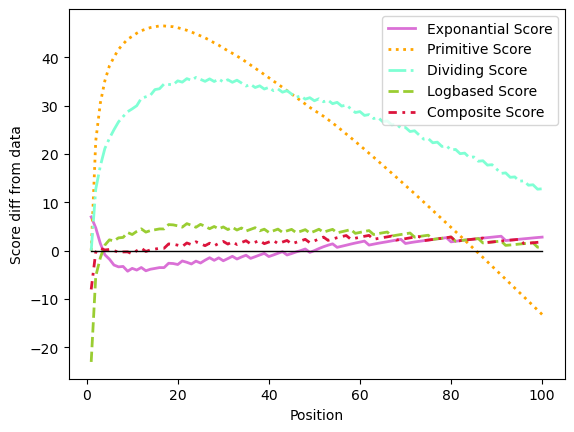

In [305]:
score_100_0_diff()

as seen in this graph difference between the different formulas and the actual data the composite function is the best.

In [306]:
df_100.corr()

,Streams,exponential_score,primitive_score,dividing_score,logbased_score,composite_score
Streams,1.000000,0.988052,0.833051,0.893704,0.980088,0.998764
exponential_score,0.988052,1.000000,0.749046,0.826069,0.941053,0.985376
primitive_score,0.833051,0.749046,1.000000,0.991147,0.914046,0.842778
dividing_score,0.893704,0.826069,0.991147,1.000000,0.950593,0.900792
logbased_score,0.980088,0.941053,0.914046,0.950593,1.000000,0.984332
composite_score,0.998764,0.985376,0.842778,0.900792,0.984332,1.000000


with a correlation of 0.9988 i think is fair to say that it correlates pretty good with the underlying data.

## Looking for mislabeled artist

### defining the function to get a artist table and graph

In [307]:
def get_artist_table(updated_or_old,score):# Function to generate an artist table with different metrics
    if updated_or_old==True:
        data_artist = up_data.copy()
    else:
        data_artist = data.copy()
    final_table=merge_artist(data_artist.groupby('artist_id')[score].sum(),artist)
    final_table=merge_artist(final_table,data_artist.groupby('artist_id')['name_y'].nunique())
    final_table=merge_artist(final_table,data_artist.groupby('artist_id')['chart_week'].count())
    final_table=merge_artist(final_table,data_artist.groupby('artist_id')['chart_year'].min())
    final_table=merge_artist(final_table,data_artist[data_artist['list_position']==1][['artist_id','chart_week']].groupby('artist_id').count())
    final_table=final_table.sort_values(by=score,ascending=False).reset_index()
    final_table=final_table.rename(columns={
        'name':'artist',
        'name_y':'songs_on_leaderboard',
        'chart_week_x':'weeks_on_leaderboard',
        'chart_week_y':'weeks_on_1st_place',
        'chart_year':'first_year_on_leaderboard',
        'popularity':'current_popularity' })
    return final_table[[score,'artist','current_popularity','songs_on_leaderboard','first_year_on_leaderboard','weeks_on_leaderboard','weeks_on_1st_place']]


in order to find outlier we need to define what is a outlier. I have tried to do this below by filtering out artist that have very high 

Defining a function and showing the graph, will display the graph again

In [308]:
def outliers_graph():
    data_artist=get_artist_table(False,'composite_score')
    x=data_artist['current_popularity']
    y=data_artist['composite_score']
    col = np.where((data_artist['composite_score'] > 200+pow(10,(0.041*(data_artist['current_popularity']+40)))),'orchid','deepskyblue')
    plt.yscale('log')
    plt.scatter(x, y, c=col, s=18)
    plt.ylabel("Score")
    plt.xlabel("Current Popularity")
    return plt.show()

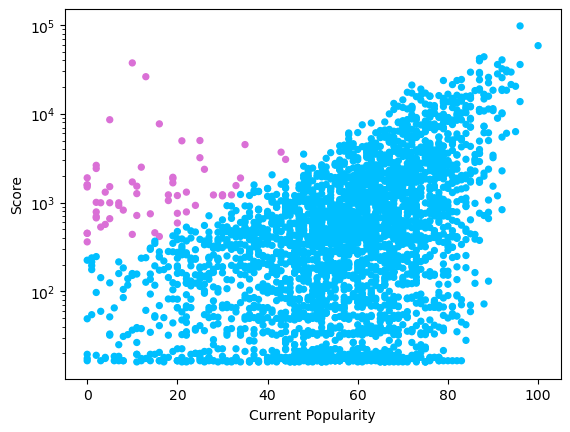

In [309]:
outliers_graph()

here i have colord the outliers pink, these artists songs are then feed to update_mapping.py where it fetch 
data from musicbrainz using it's open api. 
1. Identify outliers using formula, then remove artists with more then 25 000 followers(probably real artist)
2. Fetch the songs from the affected artists and remove non title text, for example "Let Me Blow Ya Mind (As Made Famous By Eve Featuring Gwen Stefani)" becomes "Let Me Blow Ya Mind"
3. Search musicbrainz for that song and fetch the first page of information via their API
4. extract the artists for each song
5. use Levenshtein distance to find probable existing artist in dataset
6. remove affected tracks and add new artists to an updated mapping file. remove other occurrence in original file.

        

Defining a function and showing the graph, will display the graph again

In [310]:
def outliers_after_clean_graph():
    up_data_artist=get_artist_table(True,'composite_score')
    x=up_data_artist['current_popularity']
    y=up_data_artist['composite_score']
    col = np.where((up_data_artist['composite_score'] > 200+pow(10,(0.041*(up_data_artist['current_popularity']+40)))),'orchid','deepskyblue')
    plt.yscale('log')
    plt.scatter(x, y, c=col, s=18)
    plt.ylabel("Score")
    plt.xlabel("Current Popularity")
    return plt.show()

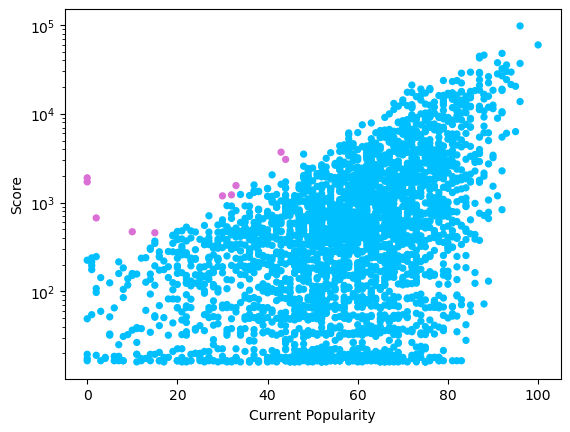

In [311]:
outliers_after_clean_graph()

as we see a lot of the outlier have disappeared. This is artist like but not limited to "The Karaoke Crew" and "DJ Cover This" with about 300 songs on the leaderboard and about 55 artists to remap. why their still is artists left that haven't be cleaned could be because their not other artist to find or that the original artist was correct.

## comparing different scoring systems

### defining function to get track table and metric for track+artist

In [312]:
def get_track_table(updated_or_old,score):# Function to generate a track table with different metrics
    if updated_or_old==True:
        track_info=merge_track(tracks,up_artist_track.groupby(['track_id'])['name_x'].unique())
    else:
        track_info=merge_track(tracks,artist_track.groupby(['track_id'])['name_x'].unique())
    track_info=merge_track(track_info,chart.groupby('track_id')['chart_week'].count())
    track_info=merge_track(track_info,chart.groupby('track_id')['chart_year'].min())
    track_info=merge_track(track_info,chart[chart['list_position']==1][['track_id',score]].groupby('track_id').count())
    data_year=merge_track(chart.groupby('track_id').sum().sort_values(by=score,ascending=False),track_info)
    data_year=data_year.rename(columns={      
    'name':'track_title',
    'chart_week_y':'weeks_on_leaderboard',
    score+'_y':'weeks_on_1st_place',
    score+'_x':score,
    'name_x':'artist',
    'chart_year_y':'first_year_on_leaderboard' })
    return data_year[['track_title',score,'artist','first_year_on_leaderboard','weeks_on_leaderboard','weeks_on_1st_place']]

def get_metric_artist(updated_or_old,score): 
    artist_data=get_artist_table(updated_or_old,score)
    artist_different_metric=pd.merge(artist_data.sort_values(by=score,ascending=False).head(25)[['artist',score]],artist_data.sort_values(by='weeks_on_1st_place',ascending=False).head(25)[['artist','weeks_on_1st_place']].reset_index(),left_index=True, right_index=True,how='outer')
    artist_different_metric=pd.merge(artist_different_metric,artist_data.sort_values(by='weeks_on_leaderboard',ascending=False).head(25)[['artist','weeks_on_leaderboard']].reset_index(),left_index=True, right_index=True,how='outer')
    artist_different_metric=artist_different_metric.rename(columns={'artist_x':'artist_'+score,'artist_y':'artist_weeks_on_1st_place','artist':'artist_weeks_on_leaderboard','index_x':score+'rank','index_y':score+'rank'})
    return artist_different_metric

def get_metric_track(updated_or_old,score):
    track_data=get_track_table(updated_or_old,score)
    track_different_metric=pd.merge(track_data.sort_values(by=score,ascending=False).head(25)[['track_title',score]],track_data.sort_values(by='weeks_on_1st_place',ascending=False).head(25)[['track_title','weeks_on_1st_place']].reset_index(),left_index=True, right_index=True,how='outer')
    track_different_metric=pd.merge(track_different_metric,track_data.sort_values(by='weeks_on_leaderboard',ascending=False).head(25)[['track_title','weeks_on_leaderboard']].reset_index(),left_index=True, right_index=True,how='outer')
    track_different_metric=track_different_metric.rename(columns={'track_title_x':'track_title_'+score,'track_title_y':'track_title_weeks_on_1st_place','track_title':'track_title_weeks_on_leaderboard','index_x':score+'rank','index_y':score+'rank'})
    return track_different_metric

getting different metrics and top performer in each metric to compare them later in the main findings.

In [313]:
track_compare_score=pd.merge(get_metric_track(True,'primitive_score').iloc[:,0:2],get_metric_track(True,'dividing_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
track_compare_score=pd.merge(track_compare_score,get_metric_track(True,'logbased_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
track_compare_score=pd.merge(track_compare_score,get_metric_track(True,'exponential_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
track_compare_score=pd.merge(track_compare_score,get_metric_track(True,'composite_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')


In [314]:

artist_compare_score=pd.merge(get_metric_artist(True,'primitive_score').iloc[:,0:2],get_metric_artist(True,'dividing_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
artist_compare_score=pd.merge(artist_compare_score,get_metric_artist(True,'logbased_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
artist_compare_score=pd.merge(artist_compare_score,get_metric_artist(True,'exponential_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')
artist_compare_score=pd.merge(artist_compare_score,get_metric_artist(True,'composite_score').iloc[:,0:2],left_index=True, right_index=True,how='outer')


In [315]:
clean_artist_compare=pd.merge(get_artist_table(False,'composite_score')[['composite_score','artist','songs_on_leaderboard']].head(25), get_artist_table(True,'composite_score')[['composite_score','artist','songs_on_leaderboard']],on='artist',how='left')
clean_artist_compare['additional_songs']=clean_artist_compare[['songs_on_leaderboard_x','songs_on_leaderboard_y']].diff(axis=1)['songs_on_leaderboard_y']
clean_artist_compare=clean_artist_compare.rename(columns={'songs_on_leaderboard_x':'track_before_clean','songs_on_leaderboard_y':'track_after_clean','composite_score_y':'score_after_clean','composite_score_x':'score_before_clean'})

# Main findings


The main findings of this project is that data cleaning matters, But not always.

1. Effect of different scoring metrics is more important then scoring model. 
    1. Scoring models: 
        1. Different scoring models don't effect top performing artist, since it takes the noise out from multiple songs.
        2.  Different scoring models effect top performing tracks since all it's a closer race to the top.
    2. Scoring metrics:
        1. Different scoring metrics effect significantly both top artist and top track.
        2. Choosing relevant metric is essential for good analysis. since i wanted to look at reach of each artist/track the best metric is a composite score.
___

2. Removing outliers/data error is important for a good top artist list
    1. Recognizing outliers is important to eliminate 'fake-artist', artist who likely haven't produced the song. Two of these fake artist mate it to the top 25 artist, 'stealing' tracks from other artist.
        1. this had the double effect of some significant reordering on the top, both from 'fake-artist' being removed but also some artist getting more tracks and climbing the leaderboard.
    2. this is not as important for a track specific analysis, since it isn't based on summarization between a lot of different potential error in data.
***


3. Almost independent of all cleaning and the top artist and song was unchanged
    1. Top artist was Drake,  followed by Taylor Swift
    2. Top song was "Blinding Lights" or "1, 2 Step (feat. Missy Elliott)"	
        
      



## Difference between scoring system

This analysis aims to estimate the overall reach of each song, compensating for the fact that Spotify streaming data isn't reliable for older tracks, as a significant portion of their total listens happened before Spotify became dominant. To address this, I use Spotify's streaming trends from 2017 to 2020 and apply those patterns retroactively using historical data from the Billboard Hot 100 chart. As shown in the graph below, there are significant differences between scoring systems, highlighting how different scores affect accuracy in this approach .

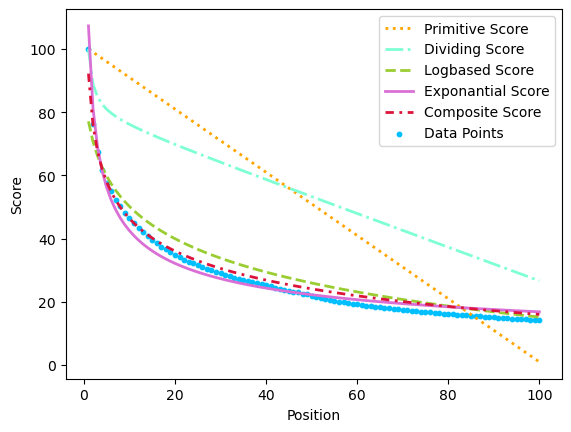

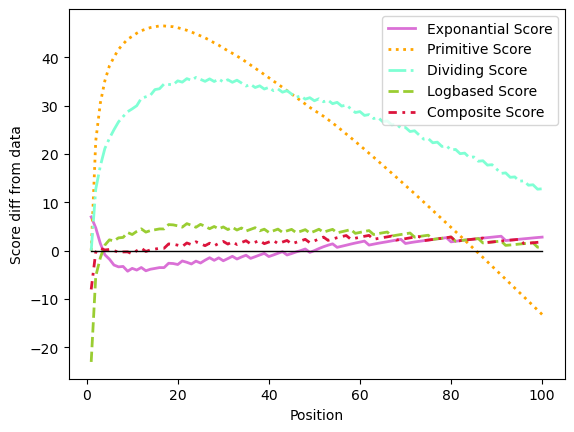

In [316]:
score_100_0()
score_100_0_diff()

The analysis below is for top artist depending of the different score models.

In [317]:
artist_compare_score[['artist_primitive_score','artist_dividing_score','artist_logbased_score','artist_exponential_score','artist_composite_score']].head(10)

,artist_primitive_score,artist_dividing_score,artist_logbased_score,artist_exponential_score,artist_composite_score
0,Drake,Drake,Drake,Drake,Drake
1,Taylor Swift,Taylor Swift,Taylor Swift,Taylor Swift,Taylor Swift
2,Rihanna,Chris Brown,Rihanna,Rihanna,Rihanna
3,Chris Brown,Lil Wayne,Chris Brown,Chris Brown,Chris Brown
4,Lil Wayne,Nicki Minaj,Lil Wayne,Lil Wayne,Lil Wayne
5,Nicki Minaj,Rihanna,Nicki Minaj,Nicki Minaj,Nicki Minaj
6,Justin Bieber,The Weeknd,Justin Bieber,Justin Bieber,Justin Bieber
7,The Weeknd,Kanye West,The Weeknd,The Weeknd,The Weeknd
8,Kanye West,Justin Bieber,Kanye West,Kanye West,Kanye West
9,Post Malone,Future,Post Malone,Post Malone,Post Malone


This suggest that for artist the different score system doesn't effect the rankings that much. The only change in the top 10 artist is in dividing_score.

The same analysis is done using track

In [318]:
track_compare_score[['track_title_primitive_score','track_title_dividing_score','track_title_logbased_score','track_title_exponential_score','track_title_composite_score']].head(10)

,track_title_primitive_score,track_title_dividing_score,track_title_logbased_score,track_title_exponential_score,track_title_composite_score
0,Blinding Lights,Blinding Lights,Blinding Lights,Blinding Lights,Blinding Lights
1,Heat Waves,"1, 2 Step (feat. Missy Elliott)","1, 2 Step (feat. Missy Elliott)","1, 2 Step (feat. Missy Elliott)","1, 2 Step (feat. Missy Elliott)"
2,"1, 2 Step (feat. Missy Elliott)",Heat Waves,Heat Waves,Heat Waves,Heat Waves
3,Wow.,Wow.,Wow.,As It Was,Wow.
4,STAY (with Justin Bieber),Radioactive,STAY (with Justin Bieber),STAY (with Justin Bieber),STAY (with Justin Bieber)
5,Radioactive,Party Rock Anthem,As It Was,Last Night,As It Was
6,Save Your Tears,STAY (with Justin Bieber),Last Night,Wow.,Last Night
7,Snooze,As It Was,All I Want for Christmas Is You,All I Want for Christmas Is You,All I Want for Christmas Is You
8,Party Rock Anthem,Save Your Tears,Circles,Uptown Funk (feat. Bruno Mars),Circles
9,Circles,All I Want for Christmas Is You,Party Rock Anthem,Shape of You,Party Rock Anthem


In this we can see an actual difference between the different systems. The top is still about the same for all with top 4 is just one switch in position. further down there is a bigger discrepancy between different tracks. here the different systems actually matters, further we will go with composite score.

## The effect of Scoring Metric

Different ranking metrics highlight different types of success in music. If we sort by composite score, tracks with broad and sustained popularity, like Blinding Lights and 1, 2 Step (feat. Missy Elliott), dominate. When ranking by weeks on the leaderboard, long-charting hits like Heat Waves and Radioactive emerge, showing longevity rather than peak dominance. However, sorting by weeks at #1 favors tracks with intense chart-topping success, such as Old Town Road - Remix and Despacito, but didn't manage to sit in the top 100 for a long time.

Each metric tells a different story: Some tracks burn bright at the top, others linger for years, and only a few manage both.


This below is top 10 different tracks by each metric

In [319]:
get_metric_track(True,'composite_score')[['track_title_composite_score','track_title_weeks_on_leaderboard','track_title_weeks_on_1st_place']].head(10)

,track_title_composite_score,track_title_weeks_on_leaderboard,track_title_weeks_on_1st_place
0,Blinding Lights,"1, 2 Step (feat. Missy Elliott)",Old Town Road - Remix
1,"1, 2 Step (feat. Missy Elliott)",Heat Waves,Despacito
2,Heat Waves,Blinding Lights,Last Night
3,Wow.,Radioactive,As It Was
4,STAY (with Justin Bieber),You Belong With Me,All I Want for Christmas Is You
5,As It Was,Wow.,We Belong Together
6,Last Night,Sail,Uptown Funk (feat. Bruno Mars)
7,All I Want for Christmas Is You,Party Rock Anthem,I Gotta Feeling
8,Circles,I'm Yours,A Bar Song (Tipsy)
9,Party Rock Anthem,Snooze,Shape of You


here is a lot difference between the different systems. If we just look at weeks_on_1st_place then we get songs that have had a big cultural impact at a specific time. None of these songs are in the top 10 tracks with most weeks on leaderboard. If we go to composite score it tries to both take chart position and weeks on leaderboard. This is a better way forward according to me, since a song on place 2 for 20 weeks shouldn't score less then one with 2 weeks on 1st place. I think that there's significant impact based on which score system you use, and i would recommend Composite score.

In [320]:
get_metric_artist(True,'composite_score')[['artist_composite_score','artist_weeks_on_leaderboard','artist_weeks_on_1st_place']].head(10)

,artist_composite_score,artist_weeks_on_leaderboard,artist_weeks_on_1st_place
0,Drake,Drake,Rihanna
1,Taylor Swift,Taylor Swift,Drake
2,Rihanna,Lil Wayne,Taylor Swift
3,Chris Brown,Chris Brown,Adele
4,Lil Wayne,Nicki Minaj,Mariah Carey
5,Nicki Minaj,Rihanna,USHER
6,Justin Bieber,Future,Bruno Mars
7,The Weeknd,Kanye West,Beyoncé
8,Kanye West,The Weeknd,Katy Perry
9,Post Malone,Justin Bieber,Black Eyed Peas


here we can see a clear trend with Drake and Taylor Swift on the top. Rihanna is the king/queen of make number one hits. Here we can see a clear preference for prolific authors which release a lot of songs in composite score, while it doesn't matter as much for number one hits.  

## How to identify Outliers

Identifying outliers is done by extracting their current popularity and composite score. The threshold is set using an exponential function, which was taken by trying different formulas until all that lied out of the cone in the graph. It creates a scatter plot with a logarithmic y-axis, where each point represents an artist and the pink artists is selected as a outlier. there as about 55 outliers with a combined 300 tracks.


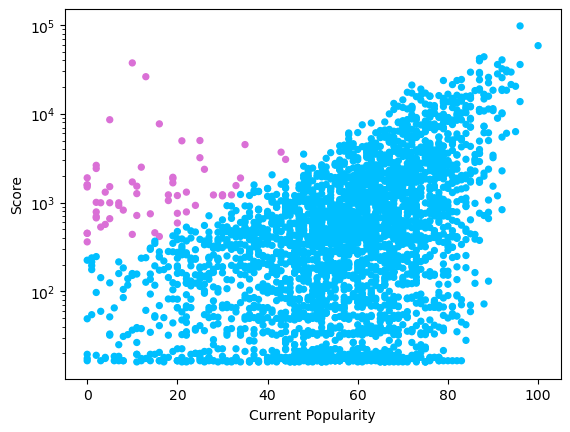

In [321]:
outliers_graph()

## Remapping outliers to proper artists

The code starts by taking a list of song titles and querying the MusicBrainz API to find potential matching artists. It stores the retrieved artists and song title in a DataFrame, ensuring that multiple artist credits for a single song are also captured. It choose based on a scoring system which artists to assign the different tracks to. If the identified artists already exist in the dataset it is assigned to it. 

This gave 195 of the 285 outliers tracks a new existing author in the dataset and could be incorporated into the mapping. 

For the remainder of the tracks I used Levenshtein distance to compare artist names and find the closest match, and assigns it when under a certain threshold(1). Finally, it updates the dataset with the corrected artist-to-song mappings and saves the cleaned data.

In [322]:
artist_to_compare[artist_to_compare['dist']<=1].drop_duplicates()

,artist,closest_match,popularity,dist
2,Ne‐Yo,Ne-Yo,83,1.0
3,T‐Pain,T-Pain,80,1.0
9,Afrojack,AFROJACK,75,0.0
13,Usher,USHER,83,0.0
27,Olivia O’Brien,Olivia O'Brien,66,1.0
38,YC,YG,74,1.0
62,Leah,Lea,48,1.0
63,Boys Like Girls,BOYS LIKE GIRLS,62,0.0
65,The‐Dream,The-Dream,65,1.0
73,Diddy – Dirty Money,Diddy - Dirty Money,52,1.0


The artists which found a existing artist thanks to Levenshtein Distance. Left is 80 songs which couldn't find a artist for. that's about 70% of songs which found new owners. Below is the outlier chart after cleaning

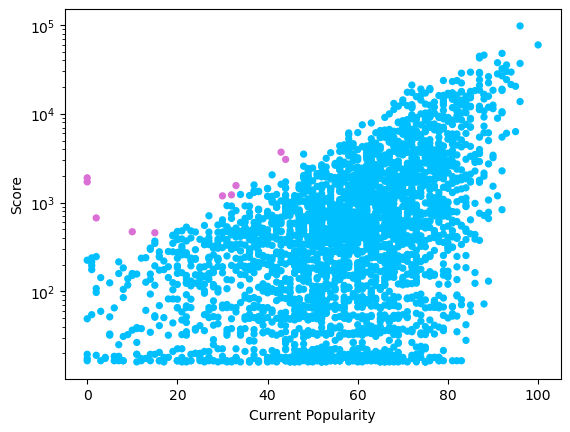

In [323]:
outliers_after_clean_graph()

## Cleanings effect of top artist

Cleaning affected a lot of artist in the top 25 with some artists gaining upwards of 10% more songs and Rihanna increasing her rank from 5 -> 3. Drake is still at the top.

In [324]:
clean_artist_compare

,score_before_clean,artist,track_before_clean,score_after_clean,track_after_clean,additional_songs
0,97816.0,Drake,313,97816.0,313.0,0.0
1,58629.0,Taylor Swift,236,59764.0,238.0,2.0
2,43911.5,Chris Brown,104,45851.0,109.0,5.0
3,42086.0,Lil Wayne,147,44498.0,152.0,5.0
4,40561.0,Rihanna,53,47976.5,58.0,5.0
5,39536.0,Nicki Minaj,124,42575.0,128.0,4.0
6,37458.0,DJ Cover This,53,NaN,NaN,NaN
7,35959.5,Justin Bieber,91,37657.5,95.0,4.0
8,35952.0,The Weeknd,93,36957.5,94.0,1.0
9,32217.0,Post Malone,93,32217.0,93.0,0.0


This table ranks artists based on song scores before and after data cleaning, showing how adjustments impacted their songs released. Some, like Drake don't get any songs, while other like Rihanna or Usher get almost 10% extra songs. this affect both of their rankings, Rihanna from place 5 to 3 and Usher from place 21 to 15. DJ Cover This and The Karaoke Crew,  two artist with minimal amount of following , were remapped to other artists. I feel that the cleaning did a great deal to get the actual most popular artist, since there were some big changes in the top 25. it's clear that Drake is the top artist based on both songs and score.